In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from glob import glob
import math
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import json
import random
import pandas as pd
from tqdm import tqdm
import trimesh
import pickle

import torch

from ANALYSIS.analysis_utils import (
    plot_panel_info,
    visualize_meshes_plotly,
    filter_segmentation_map,
    filter_segmentation_map_clusters,
    is_clockwise,
)

from env_constants import SEWFORMER_PROJ_ROOT, DATASET_ROOT, PYGARMENT_ROOT

sys.path.append(PYGARMENT_ROOT)

import pygarment as pyg

In [2]:
garment_df = pd.read_csv("garment_df_20250215_165422.csv")

filtered_combination_name_list = np.unique(garment_df[
    garment_df["mesh_filter_failed"] == False
]["matching_combination_name"]).tolist()

filtered_combination_path_list = list(map(
    lambda x : os.path.join(DATASET_ROOT, 'sewfactory', x),
    filtered_combination_name_list
))

In [3]:
import json
import numpy as np
import smplx
import torch
import trimesh


SMPLH_PATH = os.path.join(
    SEWFORMER_PROJ_ROOT, "Sewformer", "assets",
)

# Create SMPL-H model
model = smplx.create(
    model_path=SMPLH_PATH,
    model_type='smplh',  # Specifically use SMPL-H
    ext='pkl',
    gender='female',
    use_pca=False,  # Important: disable PCA for hand poses
    batch_size=1,
)

In [ ]:
# Handle Posed Body








In [4]:
# import os
# import platform
# if platform.system() == 'Linux':
#     os.environ["PYOPENGL_PLATFORM"] = "egl"
# os.environ["PYOPENGL_PLATFORM"] = "egl"
# os.environ['MESA_GL_VERSION_OVERRIDE'] = '4.1' 
# os.environ['MESA_GLSL_VERSION_OVERRIDE'] = '410'

import pyrender
from plotly import graph_objects as go

In [96]:
# Render and annotate Single Static Pose Sample


IDX = 1377 # 무뉘가 있음
IDX = 1210 # 무늬가 지림
IDX = 673
IDX = 200
IDX = random.randint(0, len(filtered_combination_path_list) - 1)

print(IDX)

combination_path = filtered_combination_path_list[IDX]

spec_config_path = os.path.join(combination_path, "static", "spec_config.json")
with open(spec_config_path, "r") as f:
    spec_config = json.load(open(spec_config_path, "r"))

combination_garment_name_list = list(map(
    lambda x : os.path.basename(x["spec"].replace("\\", "/")),
    spec_config.values()
))

static_camera_dict = {}
for camera_path in sorted(glob(os.path.join(combination_path, "static", "*cam_pos.json"))):
    with open(camera_path, "r") as f:
        camera_data = json.load(f)
    camera_name = os.path.basename(camera_path).replace("_cam_pos.json", "")
    static_camera_dict[camera_name] = camera_data
    

with open(os.path.join(combination_path, "static", "static__body_info.json"), "r") as f:
    static_body_data = json.load(f)
    betas = torch.tensor(static_body_data['shape'], dtype=torch.float32).unsqueeze(0)
    pose = torch.tensor(
        np.deg2rad(static_body_data['pose']),
        dtype=torch.float32
    ).unsqueeze(0)  # Shape: (1, 52, 3)
    transl = torch.tensor(static_body_data['trans'], dtype=torch.float32).unsqueeze(0)

    body_pose = pose[0, 1:22].reshape(1, -1)  # Body joints (excluding global orientation)
    left_hand_pose = pose[0, 22:37].reshape(1, -1)  # Left hand joints
    right_hand_pose = pose[0, 37:52].reshape(1, -1)  # Right hand joints
    global_orient = pose[0, 0].unsqueeze(0)  # Global orientation

    # Get body mesh
    output = model(
        betas=betas,
        body_pose=body_pose,
        global_orient=global_orient,
        left_hand_pose=left_hand_pose,
        right_hand_pose=right_hand_pose,
        # transl=transl
    )
    vertices = output.vertices.detach().numpy()[0]
    faces = model.faces

    # SCALE = 2 * transl.numpy()[0, 1] / (vertices[:, 1].max() - vertices[:, 1].min())
    SCALE = 95
    Z_OFFSET = -2.2
    Y_OFFSET = 21.2

    static_body_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    static_body_mesh.apply_scale(SCALE)

    static_body_mesh.vertices += transl.numpy()
    # static_body_mesh.vertices[:, 1] -= static_body_mesh.vertices[:, 1].min()
    static_body_mesh.vertices[:, 2] += Z_OFFSET
    static_body_mesh.vertices[:, 1] += Y_OFFSET

static_garment_dict = {}
for garment_name in combination_garment_name_list :
    mesh_path = os.path.join(
        combination_path, "static", f"{garment_name}_{garment_name}.obj"
    )
    mesh = trimesh.load_mesh(mesh_path, process=False)
    with open(
        os.path.join(combination_path, "static", f"{garment_name}_{garment_name}_segmentation_filtered.txt"),
        "r"
    ) as f:
        mesh_segmentation_list = list(map(
            lambda x : x.strip(),
            f.readlines()
        ))
    texture_image = Image.open(os.path.join(
        combination_path, "static", f"{garment_name}_{garment_name}_uv.png"
    ))
    mesh.visual = trimesh.visual.TextureVisuals(
        mesh.visual.uv,
        texture_image
    )
    mesh.visual.material.doubleSided = True
    
    static_garment_dict[garment_name] = {
        "mesh" : mesh,
        "mesh_segmentation_list" : mesh_segmentation_list
    }

static_cam_name_list = list(static_camera_dict.keys())
for static_cam_name in static_cam_name_list :
    cam = static_camera_dict[static_cam_name]
    cam_T = np.array(cam["cam_T"])
    cam_R = np.array(cam["cam_R"])
    cam_pose = np.eye(4)
    cam_pose[:3, 3] = cam_T
    cam_pose[:3, :3] = cam_R
    cam_direction = -cam_R[:, 2]

    body_material = pyrender.MetallicRoughnessMaterial(
        baseColorFactor=(0.0, 0.0, 0.0, 1.0),  # RGB color, Alpha
        metallicFactor=0.658,  # Range: [0.0, 1.0]
        roughnessFactor=0.5  # Range: [0.0, 1.0]
    )
    pyrender_body_mesh = pyrender.Mesh.from_trimesh(
        static_body_mesh, material=body_material
    )

    pyrender_garment_mesh_list = [
        pyrender.Mesh.from_trimesh(mesh_dict["mesh"]) for mesh_dict in static_garment_dict.values()
    ]

    cam_K = np.array(cam["cam_K"])
    fx = cam_K[0, 0]    
    fy = cam_K[1, 1]
    cx = cam_K[0, 2]
    cy = cam_K[1, 2]

    pyrender_cam = pyrender.PerspectiveCamera(
        yfov = (
            np.rad2deg(np.arctan(cy / fx)) * 2 * 4.0017
        )
    )
    scene = pyrender.Scene(bg_color=[1.0, 1.0, 1.0, 0.0])
    scene.add(pyrender_body_mesh)
    for pyrender_garment_mesh in pyrender_garment_mesh_list:
        scene.add(pyrender_garment_mesh)
    scene.add(pyrender_cam, pose=cam_pose)

    camera_node = list(filter(
        lambda x : x.camera is not None,
        scene.get_nodes()
    ))[-1]
    intensity = 80.
    light_positions = [
        np.array([1.60614, 1.5341, 1.23701]),
        np.array([1.31844, 1.92831, -2.52238]),
        np.array([-2.80522, 1.2594, 2.34624]),
        np.array([0.160261, 1.81789, 3.52215]),
        np.array([-2.65752, 1.41194, -1.26328])
    ]
    light_colors = [
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0]
    ]

    for i in range(5):
        light = pyrender.PointLight(color=light_colors[i], intensity=intensity)
        light_pose = np.eye(4)
        light_pose[:3, 3] = light_positions[i]
        scene.add(light, pose=light_pose)

    r = pyrender.OffscreenRenderer(
        viewport_width=1024, viewport_height=1024
    )
    flags = pyrender.RenderFlags.SKIP_CULL_FACES
    color, depth = r.render(scene, flags=flags)
    r.delete()

    # calculate visible vertices
    view_matrix = np.linalg.inv(scene.get_pose(camera_node))
    proj_matrix = camera_node.camera.get_projection_matrix(1024, 1024)

    for garment_name, garment_mesh in static_garment_dict.items() :
        vertices_homog = np.hstack([
            garment_mesh["mesh"].vertices,
            np.ones((garment_mesh["mesh"].vertices.shape[0], 1))
        ])

        view_proj = proj_matrix @ view_matrix
        projected = vertices_homog @ view_proj.T

        z_coords = projected[:, 2].copy()
        projected = projected[:, :3] / projected[:, 3:4]

        pixel_coords = np.zeros((projected.shape[0], 2))
        pixel_coords[:, 0] = (projected[:, 0] + 1.0) * 1024 / 2.0
        pixel_coords[:, 1] = 1024 - (projected[:, 1] + 1.0) * 1024 / 2.0

        px = np.clip(pixel_coords[:, 0].astype(int), 0, 1024 - 1)
        py = np.clip(pixel_coords[:, 1].astype(int), 0, 1024 - 1)

        THRESHOLD = -0.5
        visibility_mask = (z_coords > 0) & \
                    (pixel_coords[:, 0] >= 0) & (pixel_coords[:, 0] < 1024) & \
                    (pixel_coords[:, 1] >= 0) & (pixel_coords[:, 1] < 1024) & \
                    (z_coords + THRESHOLD < depth[py, px])
                    
                    
        garment_mesh["visibility_mask"] = visibility_mask
        garment_mesh["pixel_coords"] = pixel_coords
        
        # static_img_path = os.path.join(
        #     combination_path, "static", f"{static_cam_name.replace('cam_pos.json', '.png')}"
        # )
        with open(os.path.join(
            combination_path, "static",
            f"{static_cam_name.replace('cam_pos.json', '')}_{garment_name}_{garment_name}_visibility_mask.pkl"
        ), "wb") as f:
            pickle.dump(visibility_mask, f)
        with open(os.path.join(
            combination_path, "static",
            f"{static_cam_name.replace('cam_pos.json', '')}_{garment_name}_{garment_name}_pixel_coords.pkl"
        ), "wb") as f:
            pickle.dump(pixel_coords, f)

    # static_img_path = os.path.join(
    #     combination_path, "static", f"{static_cam_name.replace('cam_pos.json', '.png')}"
    # )
    # static_image = Image.open(static_img_path)


1210


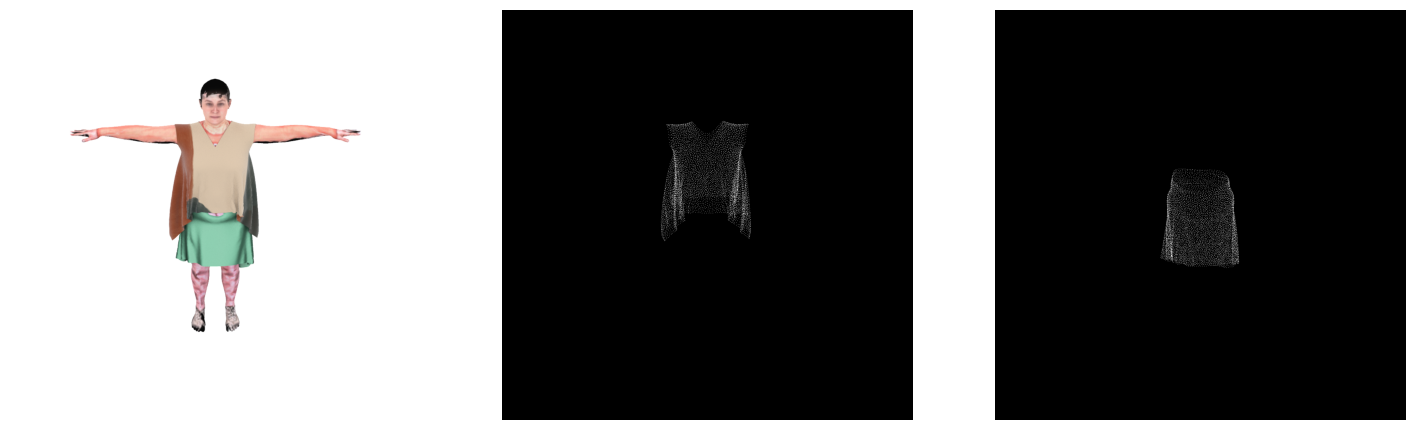

In [115]:
# Verify

spec_config_path = os.path.join(combination_path, "static", "spec_config.json")
with open(spec_config_path, "r") as f:
    spec_config = json.load(open(spec_config_path, "r"))

combination_garment_name_list = list(map(
    lambda x : os.path.basename(x["spec"].replace("\\", "/")),
    spec_config.values()
))

static_camera_dict = {}
for camera_path in sorted(glob(os.path.join(combination_path, "static", "*cam_pos.json"))):
    with open(camera_path, "r") as f:
        camera_data = json.load(f)
    camera_name = os.path.basename(camera_path).replace("_cam_pos.json", "")
    static_camera_dict[camera_name] = camera_data
    

static_cam_name_list = list(static_camera_dict.keys())
static_cam_name = random.choice(static_cam_name_list)

with open(os.path.join(combination_path, "static", "static__body_info.json"), "r") as f:
    static_body_data = json.load(f)
    betas = torch.tensor(static_body_data['shape'], dtype=torch.float32).unsqueeze(0)
    pose = torch.tensor(
        np.deg2rad(static_body_data['pose']),
        dtype=torch.float32
    ).unsqueeze(0)  # Shape: (1, 52, 3)
    transl = torch.tensor(static_body_data['trans'], dtype=torch.float32).unsqueeze(0)

    body_pose = pose[0, 1:22].reshape(1, -1)  # Body joints (excluding global orientation)
    left_hand_pose = pose[0, 22:37].reshape(1, -1)  # Left hand joints
    right_hand_pose = pose[0, 37:52].reshape(1, -1)  # Right hand joints
    global_orient = pose[0, 0].unsqueeze(0)  # Global orientation

    # Get body mesh
    output = model(
        betas=betas,
        body_pose=body_pose,
        global_orient=global_orient,
        left_hand_pose=left_hand_pose,
        right_hand_pose=right_hand_pose,
        # transl=transl
    )
    vertices = output.vertices.detach().numpy()[0]
    faces = model.faces

    # SCALE = 2 * transl.numpy()[0, 1] / (vertices[:, 1].max() - vertices[:, 1].min())
    SCALE = 95
    Z_OFFSET = -2.2
    Y_OFFSET = 21.2

    static_body_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    static_body_mesh.apply_scale(SCALE)

    static_body_mesh.vertices += transl.numpy()
    # static_body_mesh.vertices[:, 1] -= static_body_mesh.vertices[:, 1].min()
    static_body_mesh.vertices[:, 2] += Z_OFFSET
    static_body_mesh.vertices[:, 1] += Y_OFFSET
    

static_garment_dict = {}
for garment_name in combination_garment_name_list :
    mesh_path = os.path.join(
        combination_path, "static", f"{garment_name}_{garment_name}.obj"
    )
    mesh = trimesh.load_mesh(mesh_path, process=False)
    with open(
        os.path.join(combination_path, "static", f"{garment_name}_{garment_name}_segmentation_filtered.txt"),
        "r"
    ) as f:
        mesh_segmentation_list = list(map(
            lambda x : x.strip(),
            f.readlines()
        ))
    texture_image = Image.open(os.path.join(
        combination_path, "static", f"{garment_name}_{garment_name}_uv.png"
    ))
    mesh.visual = trimesh.visual.TextureVisuals(
        mesh.visual.uv,
        texture_image
    )
    mesh.visual.material.doubleSided = True
    
    with open(os.path.join(
        combination_path, "static",
        f"{static_cam_name.replace('cam_pos.json', '')}_{garment_name}_{garment_name}_visibility_mask.pkl"
    ), "rb") as f:
        visibility_mask = pickle.load(f)
    with open(os.path.join(
        combination_path, "static",
        f"{static_cam_name.replace('cam_pos.json', '')}_{garment_name}_{garment_name}_pixel_coords.pkl"
    ), "rb") as f:
        pixel_coords = pickle.load(f)
        
    static_garment_dict[garment_name] = {
        "mesh" : mesh,
        "mesh_segmentation_list" : mesh_segmentation_list,
        "visibility_mask" : visibility_mask,
        "pixel_coords" : pixel_coords
    }
    
static_img_path = os.path.join(
    combination_path, "static", f"{static_cam_name.replace('cam_pos.json', '.png')}"
)
static_image = Image.open(static_img_path)

NCOLs = len(static_garment_dict) + 1
NROWs = 1
FIGLEN = 6
plt.figure(figsize=(NCOLs * FIGLEN, NROWs * FIGLEN))
plt.subplot(1, NCOLs, 1)
plt.imshow(static_image)
plt.axis('off')
for i, (garment_name, garment_mesh) in enumerate(static_garment_dict.items(), start=1):
    plt.subplot(1, NCOLs, i + 1)
    img = np.ones((1024, 1024, 1), dtype=np.uint8)
    pixel_coords = garment_mesh["pixel_coords"].astype(np.int32)
    img[pixel_coords[:, 1], pixel_coords[:, 0]] = 255
    plt.imshow(img, cmap="gray")
    plt.axis('off')
plt.show()


visualize_meshes_plotly(
    [static_body_mesh] + list(map(
        lambda x : x["mesh"],
        static_garment_dict.values()
    )),
    vertices_list = list(map(
        lambda x : x["mesh"].vertices[x["visibility_mask"]],
        static_garment_dict.values()
    )) + list(map(
        lambda x : x["mesh"].vertices[~x["visibility_mask"]],
        static_garment_dict.values()
    )),
    vertices_color_list=["red"] * len(static_garment_dict) + ["blue"] * len(static_garment_dict),
    show_edges=False,
)
        
    

In [100]:
pixel_coords

array([[609.30818184, 668.75702074],
       [609.30818184, 668.75702074],
       [614.59290042, 670.88547865],
       ...,
       [551.45927355, 541.19256728],
       [532.86864971, 513.22775792],
       [494.21130983, 686.08738021]])

In [107]:
cam_name_list

['static_0_30cam_pos.json',
 'static_120_0cam_pos.json',
 'static_120_30cam_pos.json',
 'static_150_0cam_pos.json',
 'static_150_30cam_pos.json',
 'static_180_30cam_pos.json',
 'static_210_0cam_pos.json',
 'static_210_30cam_pos.json',
 'static_240_0cam_pos.json',
 'static_240_30cam_pos.json',
 'static_270_30cam_pos.json',
 'static_300_0cam_pos.json',
 'static_300_30cam_pos.json',
 'static_30_0cam_pos.json',
 'static_30_30cam_pos.json',
 'static_330_0cam_pos.json',
 'static_330_30cam_pos.json',
 'static_60_0cam_pos.json',
 'static_60_30cam_pos.json',
 'static_90_30cam_pos.json',
 'static_backcam_pos.json',
 'static_frontcam_pos.json',
 'static_leftcam_pos.json',
 'static_rightcam_pos.json']

217


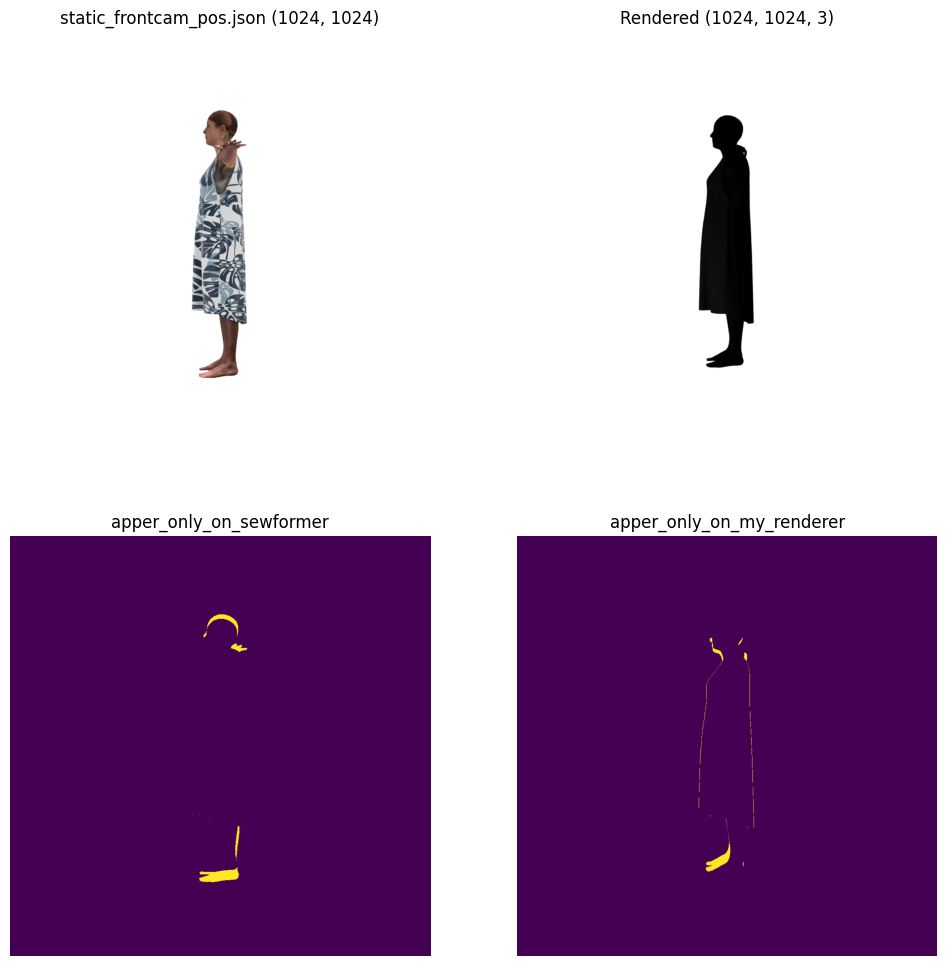

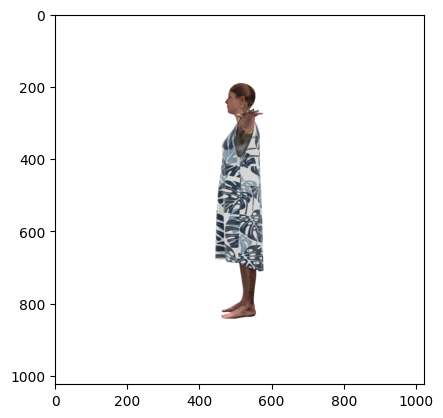

In [91]:
# Inspect "Static"

IDX = 1377 # 무뉘가 있음
IDX = 673
IDX = 200
IDX = random.randint(0, len(filtered_combination_path_list) - 1)

print(IDX)

combination_path = filtered_combination_path_list[IDX]

spec_config_path = os.path.join(combination_path, "static", "spec_config.json")
with open(spec_config_path, "r") as f:
    spec_config = json.load(open(spec_config_path, "r"))

combination_garment_name_list = list(map(
    lambda x : os.path.basename(x["spec"].replace("\\", "/")),
    spec_config.values()
))

static_camera_dict = {}
for camera_path in sorted(glob(os.path.join(combination_path, "static", "*cam_pos.json"))):
    with open(camera_path, "r") as f:
        camera_data = json.load(f)
    camera_name = os.path.basename(camera_path).replace("_cam_pos.json", "")
    static_camera_dict[camera_name] = camera_data
    

with open(os.path.join(combination_path, "static", "static__body_info.json"), "r") as f:
    static_body_data = json.load(f)
    betas = torch.tensor(static_body_data['shape'], dtype=torch.float32).unsqueeze(0)
    pose = torch.tensor(
        np.deg2rad(static_body_data['pose']),
        dtype=torch.float32
    ).unsqueeze(0)  # Shape: (1, 52, 3)
    transl = torch.tensor(static_body_data['trans'], dtype=torch.float32).unsqueeze(0)

    body_pose = pose[0, 1:22].reshape(1, -1)  # Body joints (excluding global orientation)
    left_hand_pose = pose[0, 22:37].reshape(1, -1)  # Left hand joints
    right_hand_pose = pose[0, 37:52].reshape(1, -1)  # Right hand joints
    global_orient = pose[0, 0].unsqueeze(0)  # Global orientation

    # Get body mesh
    output = model(
        betas=betas,
        body_pose=body_pose,
        global_orient=global_orient,
        left_hand_pose=left_hand_pose,
        right_hand_pose=right_hand_pose,
        # transl=transl
    )
    vertices = output.vertices.detach().numpy()[0]
    faces = model.faces

    # SCALE = 2 * transl.numpy()[0, 1] / (vertices[:, 1].max() - vertices[:, 1].min())
    SCALE = 95
    Z_OFFSET = -2.2
    Y_OFFSET = 21.2

    static_body_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    static_body_mesh.apply_scale(SCALE)

    static_body_mesh.vertices += transl.numpy()
    # static_body_mesh.vertices[:, 1] -= static_body_mesh.vertices[:, 1].min()
    static_body_mesh.vertices[:, 2] += Z_OFFSET
    static_body_mesh.vertices[:, 1] += Y_OFFSET

static_garment_dict = {}
for garment_name in combination_garment_name_list :
    mesh_path = os.path.join(
        combination_path, "static", f"{garment_name}_{garment_name}.obj"
    )
    mesh = trimesh.load_mesh(mesh_path, process=False)
    with open(
        os.path.join(combination_path, "static", f"{garment_name}_{garment_name}_segmentation_filtered.txt"),
        "r"
    ) as f:
        mesh_segmentation_list = list(map(
            lambda x : x.strip(),
            f.readlines()
        ))
    texture_image = Image.open(os.path.join(
        combination_path, "static", f"{garment_name}_{garment_name}_uv.png"
    ))
    mesh.visual = trimesh.visual.TextureVisuals(
        mesh.visual.uv,
        texture_image
    )
    mesh.visual.material.doubleSided = True
    
    static_garment_dict[garment_name] = {
        "mesh" : mesh,
        "mesh_segmentation_list" : mesh_segmentation_list
    }
static_cam_name = list(static_camera_dict.keys())[
    random.randint(0, len(static_camera_dict) - 1)
]
static_cam_name = "static_frontcam_pos.json"

cam = static_camera_dict[static_cam_name]
cam_T = np.array(cam["cam_T"])
cam_R = np.array(cam["cam_R"])
cam_pose = np.eye(4)
cam_pose[:3, 3] = cam_T
cam_pose[:3, :3] = cam_R
cam_direction = -cam_R[:, 2]
# arrow_length = 20
# arrow_start = cam_T.copy()
# arrow_end = arrow_start + cam_direction * arrow_length

body_material = pyrender.MetallicRoughnessMaterial(
    baseColorFactor=(0.0, 0.0, 0.0, 1.0),  # RGB color, Alpha
    metallicFactor=0.658,  # Range: [0.0, 1.0]
    roughnessFactor=0.5  # Range: [0.0, 1.0]
)
pyrender_body_mesh = pyrender.Mesh.from_trimesh(
    static_body_mesh, material=body_material
)

pyrender_garment_mesh_list = [
    pyrender.Mesh.from_trimesh(mesh_dict["mesh"]) for mesh_dict in static_garment_dict.values()
]

cam_K = np.array(cam["cam_K"])
fx = cam_K[0, 0]    
fy = cam_K[1, 1]
cx = cam_K[0, 2]
cy = cam_K[1, 2]

# pyrender_cam = pyrender.IntrinsicsCamera(fx, fy, cx, cy)
pyrender_cam = pyrender.PerspectiveCamera(
    yfov = (
        np.rad2deg(np.arctan(cy / fx)) * 2 * 4.0017
    )
)

scene = pyrender.Scene(bg_color=[1.0, 1.0, 1.0, 0.0])
scene.add(pyrender_body_mesh)
for pyrender_garment_mesh in pyrender_garment_mesh_list:
    scene.add(pyrender_garment_mesh)
scene.add(pyrender_cam, pose=cam_pose)

camera_node = list(filter(
    lambda x : x.camera is not None,
    scene.get_nodes()
))[-1]

intensity = 80.
light_positions = [
    np.array([1.60614, 1.5341, 1.23701]),
    np.array([1.31844, 1.92831, -2.52238]),
    np.array([-2.80522, 1.2594, 2.34624]),
    np.array([0.160261, 1.81789, 3.52215]),
    np.array([-2.65752, 1.41194, -1.26328])
]
light_colors = [
    [1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0]
]

for i in range(5):
    light = pyrender.PointLight(color=light_colors[i], intensity=intensity)
    light_pose = np.eye(4)
    light_pose[:3, 3] = light_positions[i]
    scene.add(light, pose=light_pose)

r = pyrender.OffscreenRenderer(
    viewport_width=1024, viewport_height=1024
)

# flags = pyrender.RenderFlags.RGBA | pyrender.RenderFlags.SKIP_CULL_FACES
flags = pyrender.RenderFlags.SKIP_CULL_FACES
color, depth = r.render(scene, flags=flags)

r.delete()

# calculate visible vertices
view_matrix = np.linalg.inv(scene.get_pose(camera_node))
proj_matrix = camera_node.camera.get_projection_matrix(1024, 1024)

for garment_name, garment_mesh in static_garment_dict.items() :
    vertices_homog = np.hstack([
        garment_mesh["mesh"].vertices,
        np.ones((garment_mesh["mesh"].vertices.shape[0], 1))
    ])

    view_proj = proj_matrix @ view_matrix
    projected = vertices_homog @ view_proj.T

    z_coords = projected[:, 2].copy()
    projected = projected[:, :3] / projected[:, 3:4]

    pixel_coords = np.zeros((projected.shape[0], 2))
    pixel_coords[:, 0] = (projected[:, 0] + 1.0) * 1024 / 2.0
    pixel_coords[:, 1] = 1024 - (projected[:, 1] + 1.0) * 1024 / 2.0

    px = np.clip(pixel_coords[:, 0].astype(int), 0, 1024 - 1)
    py = np.clip(pixel_coords[:, 1].astype(int), 0, 1024 - 1)

    THRESHOLD = -0.5
    visibility_mask = (z_coords > 0) & \
                (pixel_coords[:, 0] >= 0) & (pixel_coords[:, 0] < 1024) & \
                (pixel_coords[:, 1] >= 0) & (pixel_coords[:, 1] < 1024) & \
                (z_coords + THRESHOLD < depth[py, px])
                # (depth[py, px] - THRESHOLD < z_coords) & (depth[py, px] + THRESHOLD > z_coords)
                
    garment_mesh["visibility_mask"] = visibility_mask
    garment_mesh["pixel_coords"] = pixel_coords
    
    with open(os.path.join(
        combination_path, "static", f"{garment_name}_{garment_name}_visibility_mask.pkl"
    ), "wb") as f:
        pickle.dump(visibility_mask, f)
    with open(os.path.join(
        combination_path, "static", f"{garment_name}_{garment_name}_pixel_coords.pkl"
    ), "wb") as f:
        pickle.dump(pixel_coords, f)

static_img_path = os.path.join(
    combination_path, "static", f"{static_cam_name.replace('cam_pos.json', '.png')}"
)
static_image = Image.open(static_img_path)

NCOLs = 2
NROWs = 2
FIGLEN = 6
plt.figure(figsize=(NCOLs * FIGLEN, NROWs * FIGLEN))
ax1 = plt.subplot(NROWs, NCOLs, 1)
ax1.set_title(f"{static_cam_name} {static_image.size}")
ax1.imshow(static_image)
ax1.axis('off')

ax2 = plt.subplot(NROWs, NCOLs, 2)
ax2.set_title(f"Rendered {color.shape}")
ax2.imshow(color)
ax2.axis('off')

mask_1 = (np.array(static_image) < np.array([255, 255, 255])).any(axis=2).astype(np.uint8)
mask_2 = (np.array(color) < np.array([255, 255, 255])).any(axis=2).astype(np.uint8)

mask1_bigger = (mask_1 > mask_2).astype(np.uint8)
mask2_bigger = (mask_2 > mask_1).astype(np.uint8)

ax3 = plt.subplot(NROWs, NCOLs, 3)
ax3.set_title(f"apper_only_on_sewformer")
ax3.imshow(mask1_bigger)
ax3.axis('off')

ax4 = plt.subplot(NROWs, NCOLs, 4)
ax4.set_title(f"apper_only_on_my_renderer")
ax4.imshow(mask2_bigger)
ax4.axis('off')

plt.show()


fig = visualize_meshes_plotly(
    [static_body_mesh] + list(map(
        lambda x : x["mesh"],
        static_garment_dict.values()
    )),
    show_edges=False,
    vertices_list= list(map(
        lambda x : x["mesh"].vertices[x["visibility_mask"]],
        static_garment_dict.values()
    )) + list(map(
        lambda x : x["mesh"].vertices[~x["visibility_mask"]],
        static_garment_dict.values()
    )),
    vertices_color_list=["red"] * len(static_garment_dict) + ["blue"] * len(static_garment_dict)
)

plt.imshow(static_image)

In [95]:
os.path.join(
    combination_path, "static", f"{static_cam_name.replace('cam_pos.json', '')}_{garment_name}_{garment_name}_visibility_mask.pkl"
)

'/Users/hjp/HJP/KUAICV/VTO/DATASET/sewfactory/sewfactory/dress_sleeveless_NSDL331U9S/static/static_front_dress_sleeveless_NSDL331U9S_dress_sleeveless_NSDL331U9S_visibility_mask.pkl'

In [ ]:
sdfsdf 


In [ ]:
IDX = random.randint(0, len(filtered_combination_path_list) - 1)

combination_path = filtered_combination_path_list[IDX]

spec_config_path = os.path.join(combination_path, "static", "spec_config.json")
with open(spec_config_path, "r") as f:
    spec_config = json.load(open(spec_config_path, "r"))

combination_garment_name_list = list(map(
    lambda x : os.path.basename(x["spec"].replace("\\", "/")),
    spec_config.values()
))

try :
    for garment_name in combination_garment_name_list :
        spec_file_path = os.path.join(
            combination_path, "static", f"{garment_name}_specification.json"
        )
        pattern = pyg.pattern.wrappers.VisPattern(spec_file_path)
        drawn_pattern_list = list(map(
            lambda pannel_name : pattern._draw_a_panel(
                pannel_name, apply_transform=False, fill=True
            ),
            pattern.panel_order()
        ))
        panel_svg_path_dict = {
            panel_name : pattern._draw_a_panel(
                panel_name, apply_transform=False, fill=True
            )
            for panel_name in pattern.panel_order()
        }
        stitch_dict = {
            i : v for i, v in enumerate(pattern.pattern['stitches'])
        }

        mesh = trimesh.load_mesh(os.path.join(
            combination_path, "static", f"{garment_name}_{garment_name}.obj"
        ))
        with open(
            os.path.join(
                combination_path, "static", f"{garment_name}_{garment_name}_segmentation_filtered.txt"
            ),
            "r"
        ) as f:
            mesh_segmentation_list = list(map(
                lambda x : x.strip(),
                f.readlines()
            ))
            
        if len(mesh_segmentation_list) != mesh.vertices.shape[0] :    
            print(f"{combination_path} {garment_name} {mesh.vertices.shape[0]} {len(mesh_segmentation_list)}")
            mesh_len_segmentation_match = False
        else :
            mesh_len_segmentation_match = True
        
        vertex_mask_dict = {}
        for panel_name in panel_svg_path_dict.keys() :
            vertex_mask_dict[panel_name] = np.array(list(map(
                lambda x : x == panel_name,
                mesh_segmentation_list
            )))
        vertex_mask_dict["stitch"] = np.array(list(map(
            lambda x : x == "stitch",
            mesh_segmentation_list
        )))
        vertex_mask_dict["None"] = np.array(list(map(
            lambda x : x == "None",
            mesh_segmentation_list
        )))
                
                
                
                
                
                
except Exception as e :
    print(f"{combination_path}")
    print(f"{garment_name}")
    print(f"{e}")
    print()


